In [7]:
import warnings
warnings.filterwarnings('ignore')
import os

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
from glob import glob

from sklearn.model_selection import train_test_split

!pip install -qq editdistance torchsummary
import editdistance
from torchsummary import summary

seed = 42

#### As another and more classic approach: use CNN-LSTM model with OCR Loss 

In [8]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [9]:
PATH = r'../input/handwritten/synthetic-data/'
LR = 0.001
BATCH_SIZE = 32
HIDDEN = 256
ENC_LAYERS = 2
DEC_LAYERS = 2
N_HEADS = 4
DROPOUT = 0.1
IMG_WIDTH = 224  # 256
IMG_HEIGHT = 128  # 64
EPOCHS = 100

VOCAB = ['PAD', 'SOS', ' ',] + [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZqwertyuiopasdfghjklzxcvbnm'] + ['EOS']

char2idx = {char: idx for idx, char in enumerate(VOCAB)}
idx2char = {idx: char for idx, char in enumerate(VOCAB)}

In [10]:
def text_to_labels(text, char2idx=char2idx):
    return [char2idx['SOS']] + [char2idx[i.upper()] for i in text if i.upper() in char2idx.keys()] + [char2idx['EOS']]

def labels_to_text(text, idx2char=idx2char):
    S = "".join([idx2char[i] for i in text])
    if S.find('EOS') == -1:
        return S
    else:
        return S[:S.find('EOS')]

def char_error_rate(p_seq1, p_seq2):
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))

In [11]:
transforms = T.Compose([
                        T.ToPILImage(),
                        T.Resize((IMG_HEIGHT, IMG_WIDTH)),
                        T.ColorJitter(contrast=(0.5,1),saturation=(0.5,1)),
                        T.RandomRotation(degrees=(-9, 9), fill=255),
                        T.RandomAffine(10 ,None ,[0.6 ,1] ,3 ,fillcolor=255),
                        T.ToTensor()
                        ])
valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMG_HEIGHT, IMG_WIDTH)),
                              T.ToTensor()
                              ])

In [12]:
images_paths = glob(PATH+'*.png')
images_paths = sorted([str(path) for path in images_paths])
images_labels = [path.split('/')[-1].split('_')[0] for path in images_paths]
df = pd.DataFrame(data={'path': images_paths, 'label': images_labels})
df.sample(3)

,path,label
2145,../input/handwritten/synthetic-data/away_SwuK3...,away
18453,../input/handwritten/synthetic-data/say_Mx5rOi...,say
9622,../input/handwritten/synthetic-data/help_TOxo9...,help


In [13]:
df_train, df_valid = train_test_split(df, test_size=0.2, shuffle=True, random_state=seed)
print(f'Train size: {df_train.shape[0]}, validation size: {df_valid.shape[0]}')

Train size: 20105, validation size: 5027


In [14]:
class CharDataset(Dataset):
    def __init__(self, dataframe, transforms=transforms):
        self.dataframe = dataframe
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx].squeeze()
        image = cv2.imread(row['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms(image)
        label = text_to_labels(row['label'])
        return torch.FloatTensor(image), torch.LongTensor(label) 
    
    def collate_fn(self, batch):
        x_padded = []
        max_y_len = max([i[1].size(0) for i in batch])
        y_padded = torch.LongTensor(len(batch), max_y_len)
        y_padded.zero_()

        for i in range(len(batch)):
            x_padded.append(batch[i][0].unsqueeze(0))
            y = batch[i][1]
            y_padded[i, :y.size(0)] = y

        x_padded = torch.cat(x_padded)
        return x_padded.to(device), y_padded.to(device)

In [15]:
# explanation about torch transformer masks: https://stackoverflow.com/questions/62170439/difference-between-src-mask-and-src-key-padding-mask

class TransformerModel(nn.Module):
    def __init__(self, bb_name, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1, pretrained=False):
        super(TransformerModel, self).__init__()
        self.backbone = torchvision.models.__getattribute__(bb_name)(pretrained=pretrained)
        if pretrained:
            for param in self.backbone.parameters():
                param.requires_grad = False
                
        self.backbone.fc = nn.Conv2d(2048, hidden, kernel_size=1)

        self.row_embed = nn.Parameter(torch.rand(50, hidden // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden // 2))
        
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, 
                                          nhead=nhead, 
                                          num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, 
                                          dim_feedforward=hidden * 4, 
                                          dropout=dropout,
                                          batch_first=True,
                                          activation='relu')  # gelu

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)

    def generate_square_subsequent_mask(self, sz):  # decoder step: 0 - clear target token, -inf - hidden token [max_len, max_len] triangle
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)  # == <PAD>
    
    def features(self, x):
        x = self.backbone.conv1(x)

        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
            
        x = self.backbone.fc(x)  # [B, 256, 2, 8]
        
        return x

    def forward(self, src, trg):
        """ inputs, src [B, C, H, W], trg: [B, max_len] taking img size (64, 256) """
        
        x = self.features(src)  # [B, 256, 2, 8]
        _, _, H, W = x.size()
        
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),], 
            dim=-1).flatten(0, 1).unsqueeze(0)  # [1, 16, 256]  #
        
        src = pos + 0.1 * x.flatten(2).transpose(1,2)  # [1, 16, 256] + [B, 16, 256]
        
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):  # [max_len, max_len]
            self.trg_mask = self.generate_square_subsequent_mask(trg.size(1)).to(device) 
        trg_pad_mask = self.make_len_mask(trg).permute(1,0)  # [B, max_len] [s,t,pad,pad,pad] = [0,0,1,1,1], 0 - no pad, 1 - pad exists, permute as target has batch first
        
        trg = self.decoder(trg)  # [B, max_len, 256]
        trg = self.pos_decoder(trg)  # [B, max_len, 256]

        output = self.transformer(src, 
                                  trg, 
                                  tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask)  # [B, max_len, 256]

        output = self.fc_out(output)  # [B, max_len, 256] -> [B, max_len, len_vocab]
        
        return output
    
class PositionalEncoding(nn.Module):  # for text-tokens
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x) 

In [16]:
def train_one_batch(model, data, optimizer, criterion):
    model.train()
    image, target = data
    optimizer.zero_grad()
    output = model(image, target[:, :-1])
    loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(target[:, 1:], (-1,)))
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def validate_one_batch(model, data, criterion):
    model.eval()
    image, target = data
    output = model(image, target[:, :-1])
    loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(target[:, 1:], (-1,)))
    return loss.item()


def get_memory(model,images):
    x = model.features(images)
    _, _, H, W = x.size()
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(0)

    return model.transformer.encoder(pos + 0.1 * x.flatten(2).transpose(1,2))


def evaluate(model, dataloader, max_len=30):  # assuming dataloader has batch_size=1
    model.eval()
    wer_overall = 0
    cer_overall = 0
    with torch.no_grad():
        for src, trg in tqdm(dataloader, leave=False):
            out_indexes = [char2idx['SOS'], ]
            memory = get_memory(model, src)  # encode image
            
            for i in range(max_len):
                mask = model.generate_square_subsequent_mask(i+1).to(device)  # get running target mask
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(0).to(device)  # construct running target
                
                output = model.pos_decoder(model.decoder(trg_tensor))  # apply embedding, text pos encoding
                output = model.transformer.decoder(output, memory, tgt_mask=mask)  # run transformer decoder
                output = model.fc_out(output)  # get vocab size predictions (model.fc_out(output[:, -1]))
                
                out_token = output.squeeze(0).argmax(1)[-1].item()  # [B, max_len, len_vocab].squeeze(0) -B=1-> [max_len, len_vocab] take most possible token 
                if out_token == char2idx['EOS']:
                    break
                out_indexes.append(out_token)
                    
            out_char = labels_to_text(out_indexes[1:]).lower()
            real_char = labels_to_text(trg[0, 1:].detach().cpu().numpy()).lower()
            wer_overall += int(real_char != out_char)
            if out_char:
                cer = char_error_rate(real_char, out_char)
            else:
                cer = 1
            
            cer_overall += cer
    
    return cer_overall / len(dataloader) * 100, wer_overall / len(dataloader) * 100


@torch.no_grad()
def prediction(model, filepath='random', max_len=30):
    label = None
    if filepath == 'random':
        idx = np.random.randint(len(df_valid))
        filepath = df_valid.iloc[idx, 0]
        label = df_valid.iloc[idx, 1]

    model.eval()
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = valid_transforms(img)
    src = torch.FloatTensor(image).unsqueeze(0).to(device)

    out_indexes = [char2idx['SOS'], ]
    memory = get_memory(model, src)

    for i in range(max_len):
                
        mask = model.generate_square_subsequent_mask(i+1).to(device)  # get running target mask
        trg_tensor = torch.LongTensor(out_indexes).unsqueeze(0).to(device)  # construct running target
                
        output = model.pos_decoder(model.decoder(trg_tensor))  # apply embedding, text pos encoding
        output = model.transformer.decoder(output, memory, tgt_mask=mask)  # run transformer decoder
        output = model.fc_out(output)  # get vocab size predictions (model.fc_out(output[:, -1]))

        out_token = output.squeeze(0).argmax(1)[-1].item()
        if out_token == char2idx['EOS']:
            break
        out_indexes.append(out_token)
        
    preds = labels_to_text(out_indexes[1:], idx2char)
    plt.figure(figsize=(6,4))
    plt.title(f'Prediction: {preds}, Truth: {label if label is not None else "NO label"}')
    plt.imshow(img)
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)
    
    return preds

In [17]:
train_dataset = CharDataset(df_train, transforms)
valid_dataset = CharDataset(df_valid, valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [12]:
model = TransformerModel('resnet50', len(VOCAB), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS, nhead=N_HEADS, dropout=DROPOUT).to(device)

params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-6)

criterion = nn.CrossEntropyLoss(ignore_index=0)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, mode='min', patience=3, min_lr=1e-6,)

In [ ]:
train_losses, valid_losses, valid_cers, valid_wers = [], [], [], []

for epoch in range(EPOCHS):
    print(f'{epoch+1}/{EPOCHS} epoch.')
    epoch_train_losses, epoch_valid_losses = [], []
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        loss = train_one_batch(model, batch, optimizer, criterion)
        epoch_train_losses.append(loss)
        
    train_epoch_loss = np.array(epoch_train_losses).mean()
    train_losses.append(train_epoch_loss)
    
    for _, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        loss = validate_one_batch(model, batch, criterion)
        epoch_valid_losses.append(loss)
        
    valid_epoch_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(valid_epoch_loss)
    print(f'Train loss: {train_epoch_loss:.4f}, validation loss: {valid_epoch_loss:.4f}')
    
    if (epoch + 1) % 10 == 0:
        valid_cer, valid_wer = evaluate(model, valid_dataloader)
        valid_cers.append(valid_cer)
        valid_wers.append(valid_wer)
        print(f'Char_error_rate: {valid_cer:.4f}, Word_error_rate: {valid_wer:.4f}')
    
    scheduler.step(valid_epoch_loss)
    
    if (epoch+1) % 10 == 0:
        pred = prediction(model)
        torch.save(model.state_dict(), 'model.pth')

print(f'Char_error_rate: {np.mean(valid_cers):.4f}, Word_error_rate: {np.mean(valid_wers):.4f}')

In [ ]:
pred = prediction(model)

#### LabelSmothing loss

In [18]:
class LabelSmoothing(nn.Module):
    """ label smoothing """
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)  # sum every batch
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.clone()  # take size only
        true_dist.fill_(self.smoothing / (self.size - 2))  # fill distribution with small values
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)  # insert high confidence in places were true tokens exist
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target == self.padding_idx)  # create mask: =1 were padding
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)  # fill padding indexes with zero confidence
        self.true_dist = true_dist
        # compare predicted continuous (log_softmax prob scores) distribution with target distribution (were target indexes have high confidence)
        # (other indexes in target distribution have small values, padding zero values)
        loss = self.criterion(x, true_dist.detach())  
        return loss

In [19]:
model = TransformerModel('resnet50', len(VOCAB), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS, nhead=N_HEADS, dropout=DROPOUT).to(device)

params = [param for param in model.parameters() if param.requires_grad]  # update all params except resnet backbone
optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=4e-4)

criterion = LabelSmoothing(size=len(VOCAB), padding_idx=0, smoothing=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, mode='min', patience=2, min_lr=1e-7)

In [20]:
def train_one_batch(model, data, optimizer, criterion):
    model.train()
    image, target = data
    optimizer.zero_grad()
    output = model(image, target[:, :-1])
    
    norm = (target != 0).sum()
    loss = criterion(output.log_softmax(-1).contiguous().view(-1, len(VOCAB)), target[:, 1:].contiguous().view(-1).long()) / norm
    
    loss.backward()
    optimizer.step()
    
    nn.utils.clip_grad_norm_(model.parameters(), 0.2)
    
    return loss.item() * norm.item()

@torch.no_grad()
def validate_one_batch(model, data, criterion):
    model.eval()
    image, target = data
    
    output = model(image, target[:, :-1])
    norm = (target != 0).sum()
    loss = criterion(output.log_softmax(-1).contiguous().view(-1, len(VOCAB)), target[:,1:].contiguous().view(-1).long()) / norm
    
    return loss.item() * norm.item()

In [ ]:
train_losses, valid_losses, valid_cers, valid_wers = [], [], [], []

for epoch in range(EPOCHS):
    print(f'{epoch+1}/{EPOCHS} epoch.')
    epoch_train_losses, epoch_valid_losses = [], []
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        loss = train_one_batch(model, batch, optimizer, criterion)
        epoch_train_losses.append(loss)
        
    train_epoch_loss = np.array(epoch_train_losses).mean()
    train_losses.append(train_epoch_loss)
    
    for _, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        loss = validate_one_batch(model, batch, criterion)
        epoch_valid_losses.append(loss)
        
    valid_epoch_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(valid_epoch_loss)
    print(f'Train loss: {train_epoch_loss:.4f}, validation loss: {valid_epoch_loss:.4f}')
    
    if (epoch + 1) % 10 == 0:
        valid_cer, valid_wer = evaluate(model, valid_dataloader)
        valid_cers.append(valid_cer)
        valid_wers.append(valid_wer)
        print(f'Char_error_rate: {valid_cer:.4f}, Word_error_rate: {valid_wer:.4f}')
    
    scheduler.step(valid_epoch_loss)
    
    if (epoch+1) % 10 == 0:
        pred = prediction(model)
        torch.save(model.state_dict(), 'model.pth')

print(f'Char_error_rate: {np.mean(valid_cers):.4f}, Word_error_rate: {np.mean(valid_wers):.4f}')

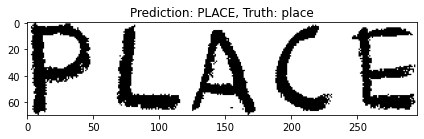

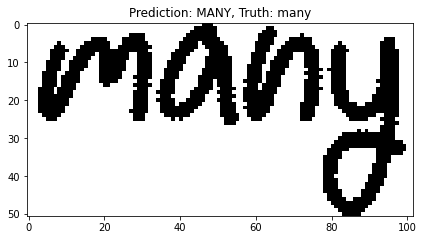

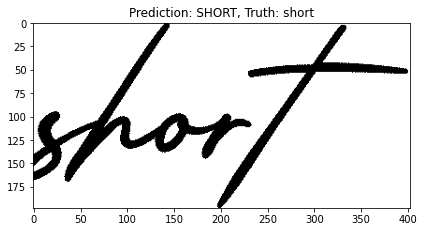

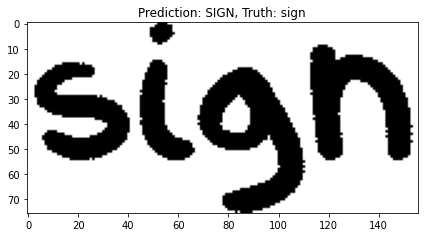

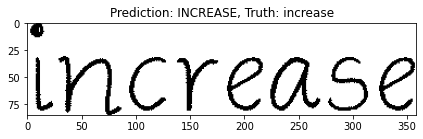

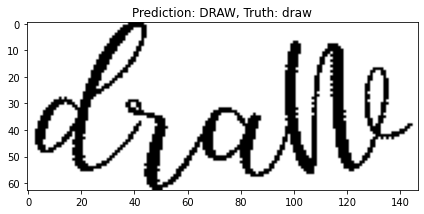

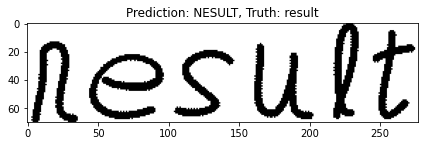

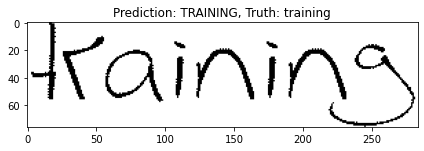

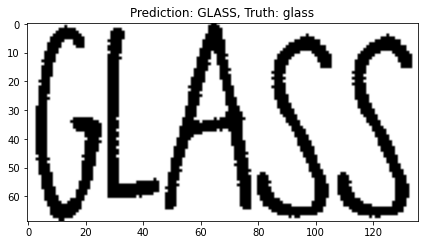

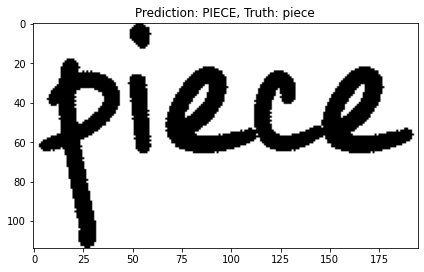

In [26]:
for _ in range(10):
    pred = prediction(model)  # results after 10 epochs

### LSTM version. 
#### Transformer model seems too complex for such task.

In [19]:
fname2label = lambda name: str(name).split('_')[0].split('/')[-1]
images = glob(PATH+'*.png')

In [20]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
BATCH, TIMESTEP, VOCAB = 64, 32, len(vocab)
H, W = 32, 128

In [21]:
class OCRDataset(Dataset):

    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=TIMESTEP):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps

    def __len__(self):
        return len(self.items)

    def sample(self):
        return self[np.random.randint(len(self))]

    def __getitem__(self, ix):
        item = self.items[ix]
        image = cv2.imread(str(item), 0)
        label = fname2label(item)
        return image, label

    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels

    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            pass
        return (255-target)/255 # add augmentations?

    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")

    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)

    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) 
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}

In [22]:
train_items, valid_items = train_test_split(glob(PATH+'*.png'), test_size=0.2, random_state=1)
train_dataset = OCRDataset(train_items)
valid_dataset = OCRDataset(valid_items)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, collate_fn=train_dataset.collate_fn, drop_last=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [23]:
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
# https://discuss.pytorch.org/t/what-is-the-difference-between-nn-dropout2d-and-nn-dropout/108192
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)
    
class Permute(nn.Module):
    def forward(self, input):
        return input.permute(2,0,1)

class Reshape(nn.Module):
    def __init__(self, shape=(256, 32)):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(-1, *self.shape)

class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(),
            Permute()
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),  # + blank
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [24]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [25]:
model = Ocr(len(vocab)).to(device)

In [26]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = train_dataset.evaluate(model, imgs.to(device), labels)
    return loss.item(), results

@torch.no_grad()
def validate_batch(data, model, criterion):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss.item(), valid_dataset.evaluate(model, imgs.to(device), labels)

In [27]:
criterion = ctc
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=3e-6)
scheduler = scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, mode='min', patience=5, min_lr=1e-6,)

In [28]:
train_losses, valid_losses = [], []

for epoch in range(EPOCHS):
    print(f'{epoch+1}/{EPOCHS} epoch.')
    epoch_train_losses, epoch_valid_losses = [], []
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        loss, train_results = train_batch(batch, model, optimizer, criterion)
        epoch_train_losses.append(loss)
        
    train_epoch_loss = np.array(epoch_train_losses).mean()
    train_losses.append(train_epoch_loss)
    
    for _, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        loss, valid_results = validate_batch(batch, model, criterion)
        epoch_valid_losses.append(loss)
        
    valid_epoch_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(valid_epoch_loss)
    print(f'Train loss: {train_epoch_loss:.4f}, validation loss: {valid_epoch_loss:.4f}')
    
    train_cer, train_wer = train_results['char-accuracy'], train_results['word-accuracy']
    valid_cer, valid_wer = valid_results['char-accuracy'], valid_results['word-accuracy']
    print(f'Train char accuracy: {train_cer:.4f}, train word accuracy: {train_wer:.4f}')
    print(f'Validation char accuracy: {valid_cer:.4f}, validation word accuracy: {valid_wer:.4f}')
    print()
    
    scheduler.step(valid_epoch_loss)
    
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), 'model.pth')

1/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 3.3272, validation loss: 3.0697
Train char accuracy: 0.0384, train word accuracy: 0.0000
Validation char accuracy: 0.0453, validation word accuracy: 0.0000

2/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 2.8650, validation loss: 2.5417
Train char accuracy: 0.3023, train word accuracy: 0.0000
Validation char accuracy: 0.2730, validation word accuracy: 0.0000

3/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 2.1589, validation loss: 1.4835
Train char accuracy: 0.5684, train word accuracy: 0.0781
Validation char accuracy: 0.5355, validation word accuracy: 0.0312

4/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 1.3060, validation loss: 0.9022
Train char accuracy: 0.8013, train word accuracy: 0.3594
Validation char accuracy: 0.6972, validation word accuracy: 0.1875

5/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.9272, validation loss: 0.6607
Train char accuracy: 0.8051, train word accuracy: 0.4219
Validation char accuracy: 0.7911, validation word accuracy: 0.3750

6/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.7103, validation loss: 0.5150
Train char accuracy: 0.8588, train word accuracy: 0.5625
Validation char accuracy: 0.8182, validation word accuracy: 0.4375

7/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.5665, validation loss: 0.4168
Train char accuracy: 0.8997, train word accuracy: 0.6562
Validation char accuracy: 0.8372, validation word accuracy: 0.5000

8/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.4627, validation loss: 0.3566
Train char accuracy: 0.9362, train word accuracy: 0.7500
Validation char accuracy: 0.8901, validation word accuracy: 0.5938

9/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.3884, validation loss: 0.3268
Train char accuracy: 0.9207, train word accuracy: 0.7188
Validation char accuracy: 0.8762, validation word accuracy: 0.5469

10/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.3321, validation loss: 0.2877
Train char accuracy: 0.9445, train word accuracy: 0.8125
Validation char accuracy: 0.9001, validation word accuracy: 0.6250

11/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.2888, validation loss: 0.2572
Train char accuracy: 0.9739, train word accuracy: 0.8906
Validation char accuracy: 0.9182, validation word accuracy: 0.7500

12/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.2527, validation loss: 0.2445
Train char accuracy: 0.9765, train word accuracy: 0.8750
Validation char accuracy: 0.9217, validation word accuracy: 0.7188

13/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.2307, validation loss: 0.2228
Train char accuracy: 0.9676, train word accuracy: 0.9062
Validation char accuracy: 0.9271, validation word accuracy: 0.7344

14/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.2037, validation loss: 0.2145
Train char accuracy: 0.9781, train word accuracy: 0.9375
Validation char accuracy: 0.9160, validation word accuracy: 0.7031

15/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1846, validation loss: 0.2008
Train char accuracy: 0.9882, train word accuracy: 0.9531
Validation char accuracy: 0.9321, validation word accuracy: 0.7500

16/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1698, validation loss: 0.2083
Train char accuracy: 0.9830, train word accuracy: 0.9062
Validation char accuracy: 0.9207, validation word accuracy: 0.7500

17/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1581, validation loss: 0.1984
Train char accuracy: 0.9800, train word accuracy: 0.9219
Validation char accuracy: 0.9235, validation word accuracy: 0.7031

18/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1493, validation loss: 0.2000
Train char accuracy: 0.9929, train word accuracy: 0.9531
Validation char accuracy: 0.9342, validation word accuracy: 0.7812

19/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1329, validation loss: 0.1976
Train char accuracy: 0.9818, train word accuracy: 0.8906
Validation char accuracy: 0.9443, validation word accuracy: 0.8125

20/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1271, validation loss: 0.1912
Train char accuracy: 1.0000, train word accuracy: 1.0000
Validation char accuracy: 0.9470, validation word accuracy: 0.7812

21/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1178, validation loss: 0.1755
Train char accuracy: 0.9723, train word accuracy: 0.8750
Validation char accuracy: 0.9377, validation word accuracy: 0.7812

22/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1172, validation loss: 0.1678
Train char accuracy: 0.9850, train word accuracy: 0.9062
Validation char accuracy: 0.9365, validation word accuracy: 0.7969

23/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1028, validation loss: 0.1799
Train char accuracy: 0.9943, train word accuracy: 0.9531
Validation char accuracy: 0.9488, validation word accuracy: 0.8281

24/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.1010, validation loss: 0.1720
Train char accuracy: 0.9927, train word accuracy: 0.9531
Validation char accuracy: 0.9529, validation word accuracy: 0.8281

25/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0970, validation loss: 0.1738
Train char accuracy: 0.9955, train word accuracy: 0.9844
Validation char accuracy: 0.9539, validation word accuracy: 0.8281

26/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0922, validation loss: 0.1717
Train char accuracy: 0.9988, train word accuracy: 0.9844
Validation char accuracy: 0.9453, validation word accuracy: 0.8125

27/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0844, validation loss: 0.1593
Train char accuracy: 0.9974, train word accuracy: 0.9844
Validation char accuracy: 0.9483, validation word accuracy: 0.8125

28/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0828, validation loss: 0.1522
Train char accuracy: 0.9948, train word accuracy: 0.9844
Validation char accuracy: 0.9513, validation word accuracy: 0.8125

29/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0798, validation loss: 0.1631
Train char accuracy: 0.9939, train word accuracy: 0.9531
Validation char accuracy: 0.9458, validation word accuracy: 0.7500

30/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0762, validation loss: 0.1728
Train char accuracy: 0.9943, train word accuracy: 0.9531
Validation char accuracy: 0.9406, validation word accuracy: 0.8125

31/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0731, validation loss: 0.1702
Train char accuracy: 0.9974, train word accuracy: 0.9844
Validation char accuracy: 0.9458, validation word accuracy: 0.7969

32/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0745, validation loss: 0.1722
Train char accuracy: 1.0000, train word accuracy: 1.0000
Validation char accuracy: 0.9567, validation word accuracy: 0.8438

33/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0701, validation loss: 0.1601
Train char accuracy: 0.9943, train word accuracy: 0.9688
Validation char accuracy: 0.9442, validation word accuracy: 0.8125

34/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0676, validation loss: 0.1657
Train char accuracy: 0.9974, train word accuracy: 0.9844
Validation char accuracy: 0.9389, validation word accuracy: 0.7656

35/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 0.0445, validation loss: 0.1415
Train char accuracy: 1.0000, train word accuracy: 1.0000
Validation char accuracy: 0.9567, validation word accuracy: 0.8438

36/100 epoch.


  0%|          | 0/314 [00:00<?, ?it/s]

KeyboardInterrupt: 

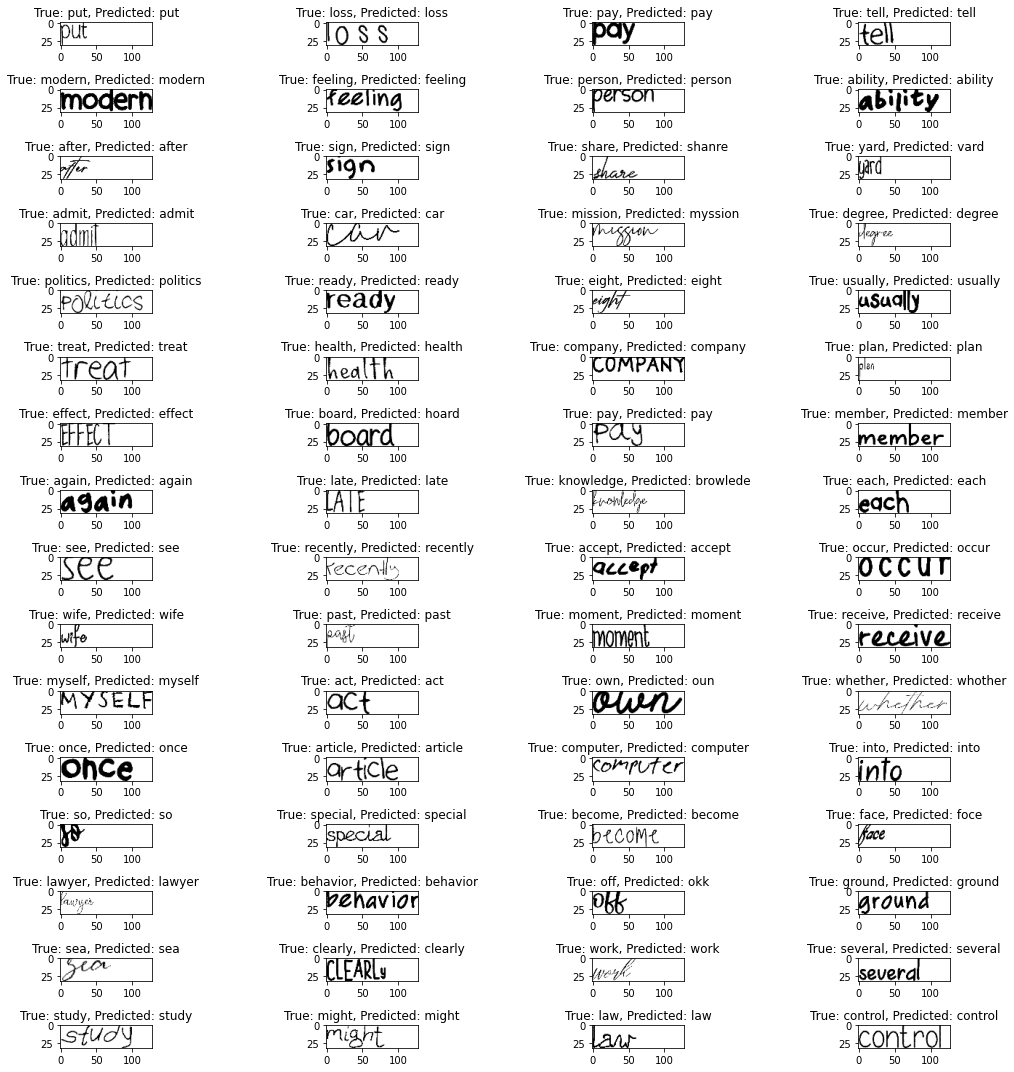

In [29]:
model.eval()
images, label_vectors, label_lengths, input_lengths, labels = next(iter(valid_dataloader))
preds = model(images).permute(1,0,2) 
preds = [valid_dataset.decoder_chars(pred) for pred in preds]
images = 255. - images.detach().cpu().numpy().squeeze() * 255 
plt.figure(figsize=(15,15))
for i in range(BATCH):
    plt.subplot(16, 4, i+1)
    plt.title(f'True: {labels[i]}, Predicted: {preds[i]}')
    plt.imshow(images[i], cmap='gray')
plt.tight_layout()
plt.show()

## TrOCR pretrained

In [30]:
class CharDataset(Dataset):
    def __init__(self, df, processor, max_target_length=32):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx].squeeze()
        image = cv2.imread(record['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(record['label'], 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids

        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [31]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = CharDataset(df=df_train, processor=processor)
eval_dataset = CharDataset(df=df_valid, processor=processor)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [32]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1").to(device)

Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 32
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [34]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = 0.0
    for pred, label in zip(pred_str, label_str):
        cer += char_error_rate(pred, label)
    cer /= len(pred_str)

    return cer

In [35]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(4):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader, leave=False):
      # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f"Loss after epoch {epoch+1}:", train_loss/len(train_dataloader))
    
    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, leave=False):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])  # very slow beacuse of for loop with strings
            valid_cer += cer 

    print("Validation CER:", valid_cer / len(eval_dataloader))

  0%|          | 0/4713 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.eval()
batch = next(iter(eval_dataloader))

with torch.no_grad():
    preds = model.generate(batch["pixel_values"].to(device))
    
labels = batch["labels"]    
pred_str = processor.batch_decode(preds, skip_special_tokens=True)
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.batch_decode(labels, skip_special_tokens=True)    

plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'True: {label_str[i]}, Predicted: {pred_str[i]}')
    plt.imshow(batch['pixel_values'][i].cpu().detach().numpy().transpose(1,2,0))
plt.tight_layout()
plt.show()